# Introduction
Data is drawn from the [Boston Property Assessment Dataset](https://data.boston.gov/dataset/property-assessment), which also provides a data key.

Because of the large size of the dataset, only residential properties were used when fitting models.

In [78]:
# libraries and settings
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import uszipcode # zip code data, will download on first import after install via pip
from uszipcode import SearchEngine
from IPython.display import display, clear_output
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# display settings
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [79]:
# read dtype and specification table from Excel
propDtypes = pd.read_excel('prop_dtypes.xlsx', index_col='col')
# fill na values in boolean cols
bool_cols = ['is_luxury', 'always_drop', 'commercial_only']
propDtypes[bool_cols] = propDtypes[bool_cols].fillna(False).astype('bool')
display(propDtypes.head(5))
# convert into dictionary for use with read_csv
dtDict = propDtypes['dtype'].to_dict()

,dtype,is_luxury,always_drop,commercial_only,value_dict,comment
col,,,,,,
PID,int64,False,False,False,NaN,NaN
CM_ID,float64,False,False,False,NaN,only useful when looking at units inside a giv...
GIS_ID,int64,False,True,False,NaN,NaN
ST_NUM,str,False,True,False,NaN,NaN
ST_NAME,str,False,True,False,NaN,NaN


In [80]:
# read raw data, allow implicit type detection even though you provide types
prop = pd.read_csv('fy19fullpropassess.csv', low_memory=False,
                  dtype=dtDict)

In [81]:
# load Boston zip codes to map neighborhoods
zipNbh = pd.read_excel('zipNeighborhoods.xlsx',
                       converters={'zip': str, 'Neighborhood': str})
zipNbh.set_index('zip', inplace=True)

# Exploratory Analysis

In [82]:
# show samples of property and zipcode data
print('Example Property Data:')
display(prop.sample(5))
print('Example Zipcode Data:')
display(zipNbh.sample(5))

Example Property Data:


,PID,CM_ID,GIS_ID,ST_NUM,ST_NAME,ST_NAME_SUF,UNIT_NUM,ZIPCODE,PTYPE,LU,OWN_OCC,OWNER,MAIL_ADDRESSEE,MAIL_ADDRESS,MAIL CS,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,STRUCTURE_CLASS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
100209,1404559004,1.404559e+09,1404559000,31,HAVELOCK,ST,2,2124,102,CD,N,BARRETT NJERI N,C/O NJERI BARRETT,31 HAVELOCK ST #2,DORCHESTER MA,2124,0,182400,182400,192250,987.0,1905.0,1987.0,987.0,987.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,N,T,6,3.0,1.0,0.0,S,NaN,NaN,F,S,W,N,0.0,N,A,A
66852,701333000,7.013330e+08,701333000,62,GATES,ST,NaN,2127,995,CM,N,SIXTY2 GATES ST CONDO TR,,62 GATES ST,S BOSTON MA,2127,0,0,0,0,1920.0,1900.0,2000.0,0.0,0.0,3.0,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LR,3.0,0.0,0.0,W,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107462,1602046000,NaN,1602046000,24 26,GARNER,RD,NaN,2122,104,R2,Y,ZIMMER JAMES M,,24 GARNER RD,DORCHESTER MA,2122,133600,431800,565400,595932,3404.0,1920.0,0.0,4443.0,2682.0,2.0,R,TF,H,M,12.0,6.0,2.0,2.0,S,S,S,2.0,S,S,NaN,W,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22233,303029332,3.030292e+08,303029200,28 32,ATLANTIC,AV,327,2110,102,CD,Y,LAUER-WILLIAMS JEANNE TS,,28 ATLANTIC AV #327,BOSTON MA,2110,0,1032600,1032600,1088361,1235.0,1850.0,1973.0,1235.0,1235.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,N,A,4,2.0,2.0,0.0,M,M,NaN,O,M,F,C,0.0,N,A,G
10550,200905006,2.009050e+08,200905000,52,SULLIVAN,ST,3,2129,102,CD,N,MURRMAN JOANNE,,52 SULLIVAN ST #3,CHARLESTOWN MA,2129,0,407900,407900,429927,1235.0,1857.0,1985.0,1235.0,680.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,N,T,3,1.0,1.0,0.0,M,NaN,NaN,F,M,W,N,0.0,N,A,A


Example Zipcode Data:


,Neighborhood
zip,
02128,East Boston
02447,Brookline
02131,Roslindale
02111,Boston Chinatown
02445,Brookline


# Cleanup and Transformation

In [83]:
# drop columns that aren't going to be used in this analysis
dropCols = list(propDtypes.loc[propDtypes['always_drop'] | propDtypes['commercial_only']].index)
print('columns to be dropped:')
display(dropCols)
prop = prop.drop(columns=list(dropCols), axis=1)
display(prop.sample(5))

columns to be dropped:


['GIS_ID',
 'ST_NUM',
 'ST_NAME',
 'ST_NAME_SUF',
 'UNIT_NUM',
 'PTYPE',
 'MAIL_ADDRESSEE',
 'MAIL_ADDRESS',
 'MAIL CS',
 'GROSS_AREA',
 'STRUCTURE_CLASS']

,PID,CM_ID,ZIPCODE,LU,OWN_OCC,OWNER,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
151372,2007013116,2.007013e+09,2467,CD,Y,LIEBMAN DEBORAH,2467,0,279600,279600,294699,793.0,1974.0,0.0,793.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,Y,A,3,1.0,1.0,0.0,M,NaN,NaN,O,M,F,C,0.0,N,A,A
52769,504049000,NaN,2215,E,N,BOSTON UNIVERSITY TRS OF,2215,767200,1454300,2221500,0,3156.0,1899.0,2002.0,7032.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95414,1400064000,NaN,2121,A,N,SECRETARY OF HOUSING,2109,206127,345217,551344,581117,6812.0,1925.0,NaN,9246.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136573,1901474000,NaN,2130,R1,Y,GRACEFFA LIA M,2130,125200,408100,533300,562098,1842.0,1900.0,1950.0,1755.0,2.0,CL,G,F,8.0,3.0,1.0,1.0,S,S,NaN,1.0,S,NaN,NaN,W,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90816,1300091000,NaN,2125,E,N,DNI 4 INC,2119,25400,0,25400,0,2776.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# fix zip codes by prepending zero
# TODO: also fix mailing zipcode
shortFlag = prop['ZIPCODE'].str.len()==4
shortZips = prop.loc[shortFlag, 'ZIPCODE']
prop.loc[shortFlag, 'ZIPCODE'] = '0' + shortZips
print('zip codes after prepending leading zero:')
display(prop['ZIPCODE'].head(10))
display(prop.sample(3))

zip codes after prepending leading zero:


0    02108
1    02108
2    02108
3    02108
4    02108
5    02108
6    02108
7    02108
8    02108
9    02108
Name: ZIPCODE, dtype: object

,PID,CM_ID,ZIPCODE,LU,OWN_OCC,OWNER,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,R_BLDG_STYL,R_ROOF_TYP,R_EXT_FIN,R_TOTAL_RMS,R_BDRMS,R_FULL_BTH,R_HALF_BTH,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,R_HEAT_TYP,R_AC,R_FPLACE,R_EXT_CND,R_OVRALL_CND,R_INT_CND,R_INT_FIN,R_VIEW,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW
131764,1811774008,1.811774e+09,02136,CP,N,TEAL JUSTIN,2136,0,6400,6400,6746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129284,1809648001,NaN,02136,E,N,COMMONWEALTH OF MASS,2136,6369800,0,6369800,0,840339.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160554,2101318000,NaN,02134,R1,N,REBAA LLC,2134,165600,375700,541300,570530,3363.0,1895.0,1999.0,2106.0,2.5,CL,H,M,6.0,3.0,2.0,0.0,S,S,NaN,1.0,S,NaN,NaN,F,N,0.0,A,A,A,N,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# count number of luxury features
luxCols = list(propDtypes.loc[propDtypes['is_luxury']].index)
print('style fields that indicate the presence of luxury finishes:')
luxVals = prop[luxCols]
display(luxVals.head(10))
# Count number of "L" values
isLux = luxVals == 'L'
nLux = isLux.sum(axis=1)
print('# of luxury finished rooms:')
display(nLux.head(10))
prop['n_lux'] = nLux

style fields that indicate the presence of luxury finishes:


,R_BTH_STYLE,R_BTH_STYLE2,R_BTH_STYLE3,R_KITCH_STYLE,R_KITCH_STYLE2,R_KITCH_STYLE3,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_STYLE
0,NaN,NaN,NaN,NaN,NaN,NaN,M,M,NaN,M
1,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,S
2,NaN,NaN,NaN,NaN,NaN,NaN,M,S,NaN,M
3,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,N
4,NaN,NaN,NaN,NaN,NaN,NaN,L,M,M,L
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,S
7,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,M
8,NaN,NaN,NaN,NaN,NaN,NaN,L,L,L,L
9,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN,NaN,M


# of luxury finished rooms:


0    0
1    0
2    0
3    0
4    2
5    0
6    0
7    0
8    4
9    0
dtype: int64

In [86]:
# merge zipcodes with neighborhood, which appears as last column
prop = pd.merge(prop, zipNbh, left_on='ZIPCODE', right_index=True, how='left')
display(prop['Neighborhood'].sample(5))

174317             Brighton
59772                Boston
164345             Brighton
115695    Dorchester Center
170494             Brighton
Name: Neighborhood, dtype: object

In [87]:
# show total properties by neighborhood
allCnts = prop['Neighborhood'].value_counts()
display(allCnts)

South Boston                14312
Jamaica Plain               11688
Brighton                    11517
Dorchester Center           10964
West Roxbury                10936
Boston Back Bay              9392
Hyde Park                    9230
Roslindale                   8987
East Boston                  8722
Boston South End             8706
Dorchester Uphams Corner     7580
Charlestown                  7171
Roxbury                      6091
Dorchester                   6091
Boston Fenway                5209
Boston West End              5209
Mattapan                     4936
Allston                      4437
Dorchester Grove Hall        4304
Boston North End             4201
Boston Kenmore               3578
Boston Chinatown             2859
Boston Downtown Crossing     2152
Boston Beacon  Hill          2130
Roxbury Mission Hill         1891
Boston                       1305
Brookline                    1055
Name: Neighborhood, dtype: int64

In [88]:
# filter to residential properties
# residential land use codes from data dictionary
# exclude condo main entries, only want condos themselves
resi_lu_codes = ['A','CD','R1','R2','R3','R4','RC','RL']
# create a copy of underlying df just in case
resi = prop.loc[prop['LU'].isin(resi_lu_codes)].copy()
# residential count by nbhd
resiCnts = resi['Neighborhood'].value_counts()


In [89]:
compDf = pd.concat([allCnts.to_frame(), resiCnts.to_frame()], axis=1)
compDf.columns = ['all', 'residential']
compDf.loc['TOTAL CITY', :] = [allCnts.sum(), resiCnts.sum()]
compDf['Pct_Residential'] = compDf['residential'] / compDf['all']
compDf = compDf.sort_values('Pct_Residential', ascending=False)
display(compDf)

,all,residential,Pct_Residential
Brookline,1055.0,1027.0,0.973460
West Roxbury,10936.0,9855.0,0.901152
Brighton,11517.0,10269.0,0.891638
Hyde Park,9230.0,8137.0,0.881582
Dorchester Center,10964.0,9590.0,0.874681
Roslindale,8987.0,7799.0,0.867809
Allston,4437.0,3821.0,0.861167
Mattapan,4936.0,4241.0,0.859198
Dorchester Grove Hall,4304.0,3648.0,0.847584
Dorchester,6091.0,5057.0,0.830241


Brookline and West Roxbury are the most residential neighborhoods in Boston.

# Predicting Condo Values: More Data Prep


### Filter to residential condo units

In [90]:
# filter to just condo units for regressions
condos = resi.loc[resi['LU'] == 'CD']
# index condos by PID, but keep column around
condos = condos.set_index('PID', drop=False)
# only one building seems to be missing CM_ID, and it's also missing other attributes like age,
#  so it's probably OK to drop it.
condos = condos.loc[~condos['CM_ID'].isnull()]

In [91]:
# drop columns related to single family homes
condos = condos.drop(columns=['R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN',
       'R_TOTAL_RMS', 'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE',
       'R_BTH_STYLE2', 'R_BTH_STYLE3', 'R_KITCH', 'R_KITCH_STYLE',
       'R_KITCH_STYLE2', 'R_KITCH_STYLE3', 'R_HEAT_TYP', 'R_AC', 'R_FPLACE',
       'R_EXT_CND', 'R_OVRALL_CND', 'R_INT_CND', 'R_INT_FIN', 'R_VIEW'])

### Join with Condo Building data

In [92]:
# extract condo main info to join with units
condoMain = prop.loc[prop['LU'] == 'CM']
condoMain.head()
condoMain.set_index('CM_ID', drop=False, inplace=True)
# remove duplicate condo main entries
condoMain = condoMain.loc[~condoMain.index.duplicated(keep='first')]

In [93]:
# join S_ columns with CM
cmCols = condoMain.columns[condoMain.columns.str.startswith('S_')]
# exclude certain columns we won't use related to mixed-use buildings and units
cmExcludeCols = {'S_UNIT_COM', 'S_UNIT_RC'}
cmCols = [cmc for cmc in cmCols if (cmc not in cmExcludeCols)]
cmCols

['S_NUM_BLDG', 'S_BLDG_STYL', 'S_UNIT_RES', 'S_EXT_FIN', 'S_EXT_CND']

In [94]:
cmData = pd.merge(condos[['PID', 'CM_ID']], condoMain[['CM_ID'] + cmCols], on='CM_ID', 
                  how='inner')
# index joined data by PID for use in fillna
cmData = cmData.set_index('PID')

In [95]:
# fix null or zero building number with 1
flagNb = cmData['S_NUM_BLDG'].isnull() | (cmData['S_NUM_BLDG'] == 0)
cmData.loc[flagNb, 'S_NUM_BLDG'] = 1

In [96]:
# fill missing condo main properties where possible, e.g. residential unit count
# hacky procedure, could be generalized though, relies on a group col (CM_ID)
fillCols = ['S_UNIT_RES']
for fc in fillCols:
    fillFlag = cmData[fc].isnull() | (cmData[fc] == 0)
    fillVal = cmData.join(cmData.groupby('CM_ID')[fc].size(), on='CM_ID', rsuffix='_r')
    cmData.loc[fillFlag, fc] = fillVal.loc[fillFlag, '{}_r'.format(fc)]


In [97]:
# loop column-wise to fill missing values in condo units
for cmC in cmCols:
    condos[cmC] = condos[cmC].fillna(cmData[cmC])

In [98]:
# add calculated column indicating multi-building complex
condos['is_in_complex'] = condos['S_NUM_BLDG'] > 1

In [99]:
# now most condos will have at least some of the condo building properties available
condos[cmCols + ['is_in_complex']].sample(5)

,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_EXT_FIN,S_EXT_CND,is_in_complex
PID,,,,,,
603773008,1.0,FS,8.0,C,G,False
604143006,1.0,RE,3.0,M,A,False
702692002,1.0,DK,3.0,W,A,False
1503026002,1.0,DK,3.0,F,G,False
503196002,1.0,RM,5.0,B,G,False


## Add Condo Age Column and Filter

In [100]:
# get latest construction year for each condo property (new or remodel)
# fill in empty remodels with year built so that there are no NaN values
condos.loc[(condos['YR_REMOD'] == 0), 'YR_REMOD'] = np.nan
condos['YR_REMOD'].fillna(condos['YR_BUILT'], inplace=True)
# in case year built was also 0, flag as nan again
condos.loc[(condos['YR_REMOD'] == 0), 'YR_REMOD'] = np.nan
condos = condos.loc[~condos['YR_REMOD'].isnull()]
display(condos['YR_REMOD'].describe())

count    63853.000000
mean      1991.380045
std         23.822814
min       1500.000000
25%       1984.000000
50%       1997.000000
75%       2006.000000
max       2018.000000
Name: YR_REMOD, dtype: float64

In [101]:
# calculate years since remodel
condos['age'] = dt.datetime.now().year - condos['YR_REMOD']
display(condos['age'].describe())

count    63853.000000
mean        27.619955
std         23.822814
min          1.000000
25%         13.000000
50%         22.000000
75%         35.000000
max        519.000000
Name: age, dtype: float64

In [102]:
# filter to condos with age <= 250 years to reduce the effect of age outliers
condos = condos.loc[condos['age'] <= 250]

### Attribute-based outlier removal

In [103]:
# exclude condo units with > 7 bedrooms (only 1 outlier)
condos = condos.loc[condos['U_BDRMS'] <= 7]
# limit to condo units with 4 or fewer full bathrooms
condos = condos.loc[condos['U_FULL_BTH'] <= 4]
# filter based on # of parking spaces, to eliminate outliers (3 units >= 6 spaces)
condos = condos.loc[condos['U_NUM_PARK'] < 6]

## Filter Assessed Value Outliers

count       63812
mean       674784
std        714466
min         41700
25%        344500
50%        488300
75%        722800
max      34057908
Name: AV_TOTAL, dtype: int32

Text(0, 0.5, 'Count')

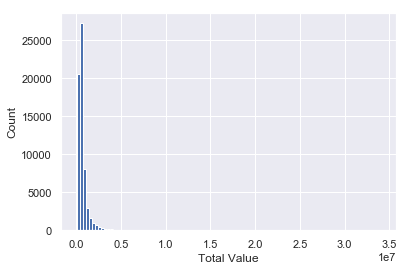

In [104]:
# examine total assessed value distribution
display(condos['AV_TOTAL'].describe().astype(int))
fig = plt.hist(condos['AV_TOTAL'], bins=100)
plt.xlabel('Total Value')
plt.ylabel('Count')

In [105]:
# figure out what percentile to cut
pctls = [0.8, 0.85, 0.9, 0.95, 0.975, 0.9825, 0.99]
display(pd.Series({k: v for k, v in zip(pctls, condos['AV_TOTAL'].quantile(pctls))}))

0.8000     808400.00
0.8500     944535.00
0.9000    1212190.40
0.9500    1783715.65
0.9750    2471590.00
0.9825    2877553.75
0.9900    3660083.20
dtype: float64

The histogram above shows that the distribution of condo values is highly right-skewed-- to limit the impact this has on our regressions, we must exclude some outliers.

Based on the percentiles above, I have chosen to limit the condos in the sample to the 95th percentile of values.

In [106]:
cutPctl = 0.95
condos = condos.loc[condos['AV_TOTAL'] <= condos['AV_TOTAL'].quantile(cutPctl)]

In [107]:
# create prediction df
# pred = condos.copy()

In [108]:
# force number of rooms to be numeric
# pred['U_TOT_RMS'] = pred['U_TOT_RMS'].astype(float, errors='ignore')

## Prepare Categorical Features

In [109]:
# define categorical columns to include and transform via get_dummies
catCols = ['ZIPCODE', 'OWN_OCC', 'S_BLDG_STYL',
       'S_EXT_FIN', 'S_EXT_CND', 'U_CORNER',
       'U_ORIENT', 'U_BTH_STYLE', 'U_BTH_STYLE2', 'U_BTH_STYLE3', 'U_KITCH_TYPE',
       'U_KITCH_STYLE', 'U_HEAT_TYP', 'U_AC', 'U_INT_FIN',
       'U_INT_CND', 'U_VIEW', 'Neighborhood', 'is_in_complex']

In [110]:
# ensure consistent capitalization across values by putting everything into upper case
for cc in catCols:
    if condos[cc].dtype == 'object':
        condos[cc] = condos[cc].str.upper()

In [111]:
# print values present for each categorical variable
# for now, leave nan values in and encode missing values as its own group
for cc in catCols:
    print(f'{cc}:\n{condos[cc].unique()}\n{condos[cc].dtype}')

ZIPCODE:
['02108' '02128' '02129' '02114' '02113' '02109' '02115' '02210' '02110'
 '02116' '02111' '02118' '02215' '02127' '02122' '02124' '02125' '02119'
 '02120' '02130' '02199' '02131' '02121' '02126' '02136' '02135' '02132'
 '02467' '02134' '02446']
object
OWN_OCC:
['Y' 'N']
object
S_BLDG_STYL:
['RM' 'RE' 'DK' 'SD' 'TH' 'FS' 'CV' 'LR' 'DX' 'MR' 'HR' 'CM' nan]
object
S_EXT_FIN:
['B' 'M' 'W' 'F' 'C' 'A' 'V' 'S' 'P' 'G' 'O' 'K' nan 'U']
object
S_EXT_CND:
['G' 'A' 'E' 'F' 'P' nan]
object
U_CORNER:
['N' 'Y']
object
U_ORIENT:
['F' 'A' 'B' 'T' 'M' 'E' 'C']
object
U_BTH_STYLE:
['M' 'S' 'N' 'L']
object
U_BTH_STYLE2:
['M' nan 'S' 'N' 'L']
object
U_BTH_STYLE3:
[nan 'S' 'M' 'L' 'N']
object
U_KITCH_TYPE:
['O' 'P' 'F' 'N']
object
U_KITCH_STYLE:
['M' 'S' 'N' 'L']
object
U_HEAT_TYP:
['W' 'F' 'E' 'P' 'S' 'N' 'O']
object
U_AC:
['N' 'C' 'D']
object
U_INT_FIN:
['N' 'S' 'E']
object
U_INT_CND:
['G' 'A' 'E' 'P' 'F']
object
U_VIEW:
['A' 'G' 'F' 'E' 'P' 'S']
object
Neighborhood:
['BOSTON BEACON  HILL' 'EAS

In [112]:
print('# of condos by neighborhood:')
condos['Neighborhood'].value_counts()

# of condos by neighborhood:


SOUTH BOSTON                6720
BRIGHTON                    5823
BOSTON BACK BAY             5124
JAMAICA PLAIN               4800
BOSTON SOUTH END            4503
CHARLESTOWN                 3427
BOSTON WEST END             3009
BOSTON FENWAY               2870
BOSTON NORTH END            2332
BOSTON KENMORE              2323
ALLSTON                     2092
DORCHESTER UPHAMS CORNER    1856
EAST BOSTON                 1837
ROSLINDALE                  1784
BOSTON CHINATOWN            1580
DORCHESTER                  1470
DORCHESTER CENTER           1465
BOSTON DOWNTOWN CROSSING    1218
WEST ROXBURY                1217
ROXBURY                      983
BOSTON BEACON  HILL          890
BROOKLINE                    834
HYDE PARK                    787
BOSTON                       588
ROXBURY MISSION HILL         436
DORCHESTER GROVE HALL        384
MATTAPAN                     269
Name: Neighborhood, dtype: int64

# Zip Code Demographic Data

In [113]:
# merge with zipcode data
search = SearchEngine(simple_zipcode=False)
# identify columns of interest from full us zip code dataset
zipCols = ['population', 'population_density', 'land_area_in_sqmi', 'water_area_in_sqmi', 
           'housing_units', 'occupied_housing_units', 'median_home_value', 'median_household_income']

In [114]:
# extract unique zips and look up
unqZips = condos['ZIPCODE'].unique()
# display(unqZips)
zipData = {}
for zc in unqZips:
    zd = search.by_zipcode(zc)   
    # too many fields, with nested sub-fields...    
    zd = zd.to_dict()
    # filter to the columns that we want    
    zf = {}
    # copy keys that don't need modification over
    for zk in zipCols:
        zf[zk] = zd[zk]    
    # manually extract earnings status
    es = zd['employment_status'][0]['values']
    d = pd.DataFrame.from_records(es)    
    d.set_index('x', inplace=True)    
    # TODO: clean up subscripting/parens here
    zf['pct_employed'] = ((d.loc['Worked Full-time With Earnings'] + d.loc['Worked Part-time With Earnings']) / d['y'].sum()).values[0]
    # calculate percentage of owner-occupied
    zf['pct_occupied'] = (zf['occupied_housing_units'] / zf['housing_units'])
    # manually extract population below 30 and above 65
    pa = zd['population_by_age'][0]['values']
    d = pd.DataFrame.from_records(pa)    
    d.set_index('x', inplace=True) 
    zf['pct_under30'] = (d.loc[:'25-29'].sum() / d['y'].sum()).values[0]
    zf['pct_over65'] = (d.loc['65-69':].sum() / d['y'].sum()).values[0]
    # manually extract population with kids
    pk = zd['households_with_kids'][0]['values']
    d = pd.DataFrame.from_records(pk)    
    d.set_index('x', inplace=True)    
    zf['pct_with_kids'] = d.loc['Households With Kids'].sum() / d['y'].sum()
    # extract percent white
    p = zd['population_by_race'][0]['values']
    d = pd.DataFrame.from_records(p)    
    d.set_index('x', inplace=True)    
    zf['pct_white'] = d['y'].loc['White'] / d['y'].sum()
    # extract percent rich (hhi > 200k)
    p = zd['household_income'][0]['values']
    d = pd.DataFrame.from_records(p)    
    d.set_index('x', inplace=True)    
    zf['pct_rich'] = d['y'].loc['$200,000+'] / d['y'].sum()
    # save filtered/extracted dictionary
    zipData[zc] = zf

# build zip code dataframe
zdf = pd.DataFrame.from_dict(zipData, orient='index')
# calculate housing unit density
zdf['housing_unit_density'] = zdf['housing_units'] / zdf['land_area_in_sqmi']
print('example zip code statistics to be merged with property data:')
display(zdf.sample(5))

example zip code statistics to be merged with property data:


,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,pct_employed,pct_occupied,pct_under30,pct_over65,pct_with_kids,pct_white,pct_rich,housing_unit_density
02135,42780,16236.0,2.63,0.22,20834,19905,350500,48687,0.699380,0.955409,0.565932,0.087525,0.110173,0.743735,0.018857,7921.673004
02215,26125,34190.0,0.76,0.11,9324,8788,366700,35659,0.758390,0.942514,0.770911,0.031389,0.034479,0.700402,0.037032,12268.421053
02128,40508,8352.0,4.85,1.14,15854,14651,290200,48704,0.737900,0.924120,0.458666,0.067561,0.348986,0.647847,0.019369,3268.865979
02113,6915,68665.0,0.10,0.00,4682,4336,449100,66636,0.855449,0.926100,0.519390,0.094723,0.037362,0.945915,0.073069,46820.000000
02122,23479,11554.0,2.03,0.63,8887,8066,320900,50192,0.658695,0.907618,0.439284,0.081441,0.377882,0.373355,0.017333,4377.832512


In [115]:
# merge zipcode data with condo data
condos = pd.merge(condos, zdf, left_on='ZIPCODE', right_index=True, how='left')
display(condos.sample(5))

,PID,CM_ID,ZIPCODE,LU,OWN_OCC,OWNER,MAIL_ZIPCODE,AV_LAND,AV_BLDG,AV_TOTAL,GROSS_TAX,LAND_SF,YR_BUILT,YR_REMOD,LIVING_AREA,NUM_FLOORS,S_NUM_BLDG,S_BLDG_STYL,S_UNIT_RES,S_UNIT_COM,S_UNIT_RC,S_EXT_FIN,S_EXT_CND,U_BASE_FLOOR,U_NUM_PARK,U_CORNER,U_ORIENT,U_TOT_RMS,U_BDRMS,U_FULL_BTH,U_HALF_BTH,U_BTH_STYLE,U_BTH_STYLE2,U_BTH_STYLE3,U_KITCH_TYPE,U_KITCH_STYLE,U_HEAT_TYP,U_AC,U_FPLACE,U_INT_FIN,U_INT_CND,U_VIEW,n_lux,Neighborhood,is_in_complex,age,population,population_density,land_area_in_sqmi,water_area_in_sqmi,housing_units,occupied_housing_units,median_home_value,median_household_income,pct_employed,pct_occupied,pct_under30,pct_over65,pct_with_kids,pct_white,pct_rich,housing_unit_density
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
306973018,306973018,3.069730e+08,02118,CD,Y,LIPTON JOHN,2118,0,724800,724800,763939,1004.0,1999.0,1999.0,1004.0,1.0,1.0,MR,28.0,NaN,NaN,B,G,2.0,0.0,N,A,4,2.0,2.0,0.0,S,S,NaN,O,S,F,C,0.0,N,G,A,0,BOSTON SOUTH END,False,20.0,26498,24075.0,1.10,0.01,12967,12314,561100,54152,0.711943,0.949641,0.387396,0.079758,0.171350,0.538003,0.126882,11788.181818
602655062,602655062,6.026550e+08,02210,CD,N,MAHANAMA THUSITH,2110,0,668600,668600,704704,747.0,1899.0,2007.0,747.0,1.0,1.0,MR,89.0,NaN,NaN,B,G,2.0,0.0,N,F,4,1.0,1.0,1.0,M,M,NaN,F,M,F,C,0.0,N,E,A,0,BOSTON,False,12.0,2090,2256.0,0.93,0.54,1358,1140,500000,110333,0.911210,0.839470,0.383516,0.040370,0.059649,0.881818,0.271760,1460.215054
203090002,203090002,2.030900e+08,02129,CD,N,ARONIS CHRISTOPHER S,2129,0,546500,546500,576011,1084.0,1880.0,1985.0,1084.0,2.0,1.0,RM,3.0,NaN,NaN,F,A,0.0,0.0,N,B,5,2.0,1.0,1.0,S,M,NaN,F,S,E,N,0.0,E,A,A,0,CHARLESTOWN,False,34.0,16439,12192.0,1.35,0.49,8648,8033,489900,86346,0.752229,0.928885,0.381605,0.098037,0.197062,0.800779,0.172699,6405.925926
2203713026,2203713026,2.203713e+09,02135,CD,N,MAGNANI ALAINA M,2135,0,217700,217700,229456,491.0,1964.0,1964.0,491.0,1.0,1.0,MR,53.0,NaN,NaN,V,A,1.0,0.0,N,F,2,0.0,1.0,0.0,S,NaN,NaN,O,S,W,N,0.0,N,A,A,0,BRIGHTON,False,55.0,42780,16236.0,2.63,0.22,20834,19905,350500,48687,0.699380,0.955409,0.565932,0.087525,0.110173,0.743735,0.018857,7921.673004
1704668002,1704668002,1.704668e+09,02124,CD,Y,SHEPARD CLARE,2124,0,412400,412400,434670,1156.0,1899.0,2004.0,1156.0,1.0,1.0,FS,6.0,NaN,NaN,F,G,1.0,1.0,N,T,6,3.0,1.0,0.0,M,NaN,NaN,O,M,F,N,1.0,N,G,A,0,DORCHESTER CENTER,False,15.0,47783,15913.0,3.00,0.07,19053,17459,306500,48841,0.676657,0.916339,0.470216,0.086052,0.382954,0.210472,0.026745,6351.000000


# Select Variables for Regression

### Target

In [116]:
# y variable in regressions
targetCol = 'AV_TOTAL'

### Continuous Variables
NaN values in any of these variables will cause a given sample to be dropped.

In [117]:
# define continuous non-categorical columns to use in regressions
contReg = ['LIVING_AREA', 'LAND_SF', 'U_BASE_FLOOR', 'U_BDRMS',
           'age', 'n_lux', 'U_NUM_PARK', 'U_FULL_BTH',
           'U_HALF_BTH', 'U_FPLACE', 'S_UNIT_RES',
           'population_density', 'water_area_in_sqmi',
           'housing_unit_density', 'median_home_value',
           'median_household_income', 'pct_employed', 'pct_occupied',
           'pct_under30', 'pct_over65', 'pct_with_kids', 'pct_white', 'pct_rich']
for ctc in contReg:
    if ctc not in condos.columns:
        print(ctc)

### Binary Variables
OHE and get_dummies can't deal with boolean values, so might as well deal with all binary variables here.

In [118]:
binReg = ['OWN_OCC', 'is_in_complex', 'U_CORNER']
# convert y/n to bit
for bc in binReg:
    if condos[bc].dtype == 'bool':        
        condos[bc] = condos[bc].astype(int)
    else:        
        try:
            condos[bc] = condos[bc].str.upper().map({'Y': 1, 'N': 0})
        except:
            pass # already int, because you re-ran this cell probably

In [119]:
# none of these columns can have missing values that would cause sample dropping
condos[binReg].isnull().any()

OWN_OCC          False
is_in_complex    False
U_CORNER         False
dtype: bool

### Categorical Variables

In [120]:
# filtered list of categorical variables to use in regression analysis
catReg = ['S_BLDG_STYL', 'S_EXT_FIN', 'S_EXT_CND', 'U_ORIENT', 'U_BTH_STYLE', 'U_KITCH_TYPE',
       'U_KITCH_STYLE', 'U_HEAT_TYP', 'U_AC', 'U_INT_FIN', 'U_INT_CND', 'U_VIEW', 'Neighborhood']

In [121]:
# how many rows have null values for each of these fields?
display(condos[catReg].isnull().sum())
# there are only 8 values that are null for 3 of the categorical columns,
#    so it's safe to drop any rows with na in any of these columns.
condos = condos.dropna(subset=catReg, how='any')

S_BLDG_STYL      8
S_EXT_FIN        8
S_EXT_CND        8
U_ORIENT         0
U_BTH_STYLE      0
U_KITCH_TYPE     0
U_KITCH_STYLE    0
U_HEAT_TYP       0
U_AC             0
U_INT_FIN        0
U_INT_CND        0
U_VIEW           0
Neighborhood     0
dtype: int64

In [123]:
# extract categorical features and convert to dummies, 
#    leaving one indicator column out to address collinearity
# use pandas to get dummy variables for these categorical columns
regDummies = pd.get_dummies(condos[catReg], drop_first=True)
dummyCols = list(regDummies.columns)
regDummies.head()

,S_BLDG_STYL_CV,S_BLDG_STYL_DK,S_BLDG_STYL_DX,S_BLDG_STYL_FS,S_BLDG_STYL_HR,S_BLDG_STYL_LR,S_BLDG_STYL_MR,S_BLDG_STYL_RE,S_BLDG_STYL_RM,S_BLDG_STYL_SD,S_BLDG_STYL_TH,S_EXT_FIN_B,S_EXT_FIN_C,S_EXT_FIN_F,S_EXT_FIN_G,S_EXT_FIN_K,S_EXT_FIN_M,S_EXT_FIN_O,S_EXT_FIN_P,S_EXT_FIN_S,S_EXT_FIN_U,S_EXT_FIN_V,S_EXT_FIN_W,S_EXT_CND_E,S_EXT_CND_F,S_EXT_CND_G,S_EXT_CND_P,U_ORIENT_B,U_ORIENT_C,U_ORIENT_E,U_ORIENT_F,U_ORIENT_M,U_ORIENT_T,U_BTH_STYLE_M,U_BTH_STYLE_N,U_BTH_STYLE_S,U_KITCH_TYPE_N,U_KITCH_TYPE_O,U_KITCH_TYPE_P,U_KITCH_STYLE_M,U_KITCH_STYLE_N,U_KITCH_STYLE_S,U_HEAT_TYP_F,U_HEAT_TYP_N,U_HEAT_TYP_O,U_HEAT_TYP_P,U_HEAT_TYP_S,U_HEAT_TYP_W,U_AC_D,U_AC_N,U_INT_FIN_N,U_INT_FIN_S,U_INT_CND_E,U_INT_CND_F,U_INT_CND_G,U_INT_CND_P,U_VIEW_E,U_VIEW_F,U_VIEW_G,U_VIEW_P,U_VIEW_S,Neighborhood_BOSTON,Neighborhood_BOSTON BACK BAY,Neighborhood_BOSTON BEACON HILL,Neighborhood_BOSTON CHINATOWN,Neighborhood_BOSTON DOWNTOWN CROSSING,Neighborhood_BOSTON FENWAY,Neighborhood_BOSTON KENMORE,Neighborhood_BOSTON NORTH END,Neighborhood_BOSTON SOUTH END,Neighborhood_BOSTON WEST END,Neighborhood_BRIGHTON,Neighborhood_BROOKLINE,Neighborhood_CHARLESTOWN,Neighborhood_DORCHESTER,Neighborhood_DORCHESTER CENTER,Neighborhood_DORCHESTER GROVE HALL,Neighborhood_DORCHESTER UPHAMS CORNER,Neighborhood_EAST BOSTON,Neighborhood_HYDE PARK,Neighborhood_JAMAICA PLAIN,Neighborhood_MATTAPAN,Neighborhood_ROSLINDALE,Neighborhood_ROXBURY,Neighborhood_ROXBURY MISSION HILL,Neighborhood_SOUTH BOSTON,Neighborhood_WEST ROXBURY
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
502550008,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502550010,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502550012,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502550014,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
502551002,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
print(f'{len(catReg)} categorical variables converted into {len(regDummies.columns)} binary features')

13 categorical variables converted into 87 binary features


In [129]:
# none of the dummy values are nan by design
regDummies.isnull().any().any()

False

In [128]:
# what's variance like among ourcategorical feature dummies?
#    extremely low variance may signal a candidate for filtering
regDummies.std().loc[regDummies.std() < 0.05]

S_BLDG_STYL_CV    0.030110
S_EXT_FIN_K       0.045726
S_EXT_FIN_P       0.037422
S_EXT_FIN_U       0.005744
S_EXT_CND_F       0.040988
S_EXT_CND_P       0.012185
U_ORIENT_E        0.045906
U_KITCH_TYPE_N    0.043137
U_HEAT_TYP_N      0.005744
U_HEAT_TYP_O      0.014069
U_HEAT_TYP_S      0.038930
U_INT_FIN_S       0.030919
U_INT_CND_P       0.021488
U_VIEW_S          0.012185
dtype: float64

Although many of the dummy variables generated from categorical features have low variance, the low variance does seem to reflect rare but significant property-related features, such as having poor exterior condition or substandard interior. Therefore, it doesn't seem like a blanket variance filter would be a good choice.

### Align samples across features and target

In [130]:
# copy original input data so we still have it for classification/clustering later
contData = condos[contReg].copy()
binData = condos[binReg].copy()
tgtData = condos[targetCol].copy()

In [131]:
regData = pd.concat([contData, binData, tgtData, regDummies.copy()], axis=1)

In [132]:
# drop any rows with nan values since they must be in continuous variables
regData = regData.dropna(how='any')

In [133]:
# separate out target with aligned NaN removals
regTgt = regData[targetCol]
regData.drop(targetCol, axis=1, inplace=True)

In [ ]:
# pair plot of selected properties
# sns.pairplot(contData[([targetCol] + ['age', 'n_lux',
#               'population_density', 'median_household_income', 'pct_employed', 'pct_occupied',
#               'pct_under30', 'pct_with_kids', 'pct_white', 'pct_rich'])])

# Machine Learning model imports

In [134]:
# sklearn and related imports
# pre-processing
import sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
# regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC    # "Support vector classifier"
from sklearn.naive_bayes import GaussianNB
# cv/metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, scorer, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
# ignore data conversion warnings when fitting models
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Linear Regression Variants (including PCA)

In [50]:
# setting for training part used
trainPct = 0.25
nFolds = 8 # for cross-validation
# helper function to run and score model/pipeline
# should be agnostic to the nature of the model itself, which could be a pipeline
def run_model(model, df, y):
    # return two dictionaries: table fields and diagnostic/non-scalar data
    res = {}
    data = {}
    train_X, test_X, train_y, test_y = train_test_split(df, y, test_size=trainPct)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    
    def add_cv_stats(scorer='r2'):
        cvr2 = cross_val_score(model, df, y, cv=nFolds, scoring=scorer)
        # return vector of r2 as data field, but calculate table cols as well
        data['cv_r2'] = cvr2
        res['cv_mean_r2'] = cvr2.mean()
        res['cv_std_r2'] = cvr2.std()  
    
    def add_linear_stats(lr):
        data['coefs'] = lr.coef_
        res['n_coeff'] = lr.coef_.size
        data['intercept'] = lr.intercept_        
        res['mae'] = mean_absolute_error(test_y, predictions)    
        res['rmse'] = mean_squared_error(test_y, predictions) ** (1/2)
        res['r2'] = r2_score(test_y, predictions)
        
    if hasattr(model, 'named_steps'):
        steps = model.named_steps # alias
    else:
        # replicate if not pipeline for consistent logic below
        steps = {f'{type(model).__name__}'.lower(): model}
    
    if 'linearregression' in steps:
        add_cv_stats(scorer='r2')
        add_linear_stats(steps['linearregression'])
        
    if 'pca' in steps:
        pca = model.named_steps['pca'] 
        res['pca_explained_pct'] = sum(pca.explained_variance_ratio_)

    data['predictions'] = predictions
    res['score'] = model.score(test_X, test_y)
    
    try:
        res['is_accuracy_score'] = accuracy_score(y, model.predict(df))
        res['oos_accuracy_score'] = accuracy_score(test_y, predictions)
    except:
        pass
    
    return res, data
    

In [138]:
# preprocessing depends on column type, so use a column transformer to apply scaler to only
#    continuous columns
def continuous_scaler(scaler):
    return make_column_transformer((scaler, contReg), remainder='passthrough')


In [135]:
# run with and without standardization
# keep models in a dictionary
linMdl = {}
linMdl['unscaled_lr'] = LinearRegression(fit_intercept=True)
linMdl['unscaled_noIntercept_lr'] = LinearRegression(fit_intercept=False)
linMdl['std_lr'] = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
linMdl['norm_lr'] = LinearRegression(fit_intercept=True, normalize=True)
# apply principal components
components_range = range(1, 11)
for ncomp in components_range:
    linMdl['std_pca{}_lr'.format(ncomp)] = make_pipeline(continuous_scaler(StandardScaler()), 
                                                         PCA(n_components=ncomp), 
                                                         LinearRegression(fit_intercept=True))
# # look at polynomial regressions; square and cubic
# poly_range = range(2, 3)
# for pfc in poly_range: # iterate over polynomial feature count
#     linMdl['std_poly{}_lr'.format(pfc)] = make_pipeline(make_scaler(StandardScaler()),
#                                                         PolynomialFeatures(degree=pfc),
#                                                         LinearRegression(fit_intercept=True))
    
# look at selecting best percentile features using f_regression
# fcRng = range(2, 9)
# percentiles, as integer, to keep
fcRng = range(5, 50, 5)
for fc in fcRng:
    linMdl['std_kBest{}_lr'.format(fc)] = make_pipeline(continuous_scaler(StandardScaler()),
                                                        SelectPercentile(f_regression,
                                                                         percentile=fc),
                                                        LinearRegression(fit_intercept=True))

In [ ]:
# another take at linear pipelines and feature selection
# 

linMdl = {}


In [136]:
# apply the model testing function above
linMdlRes = {}
for k, mdl in list(linMdl.items()):
    clear_output(wait=True)
    display('fitting {}'.format(k))
    linMdlRes[k] = run_model(mdl, regData, regTgt)    

'fitting std_kBest45_lr'

C:\Users\n0305827\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\n0305827\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\n0305827\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\n0305827\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\n0305827\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid

In [137]:
# build result dataframe
dfCols = {}
for k, (rc, rd) in linMdlRes.items():
    dfCols[k] = rc
pd.set_option('display.float_format', lambda x: '%.3f' % x)
resDf = pd.DataFrame.from_dict(dfCols, orient='index')
display(resDf)
pd.set_option('display.float_format', None)

,cv_mean_r2,cv_std_r2,n_coeff,mae,rmse,r2,score,is_accuracy_score,oos_accuracy_score,pca_explained_pct
norm_lr,-440368777051548579528704.000,765316432812680247508992.000,113,89450.309,129868.311,0.821,0.821,0.000,0.000,nan
std_kBest10_lr,0.234,0.612,12,109669.750,158603.304,0.736,0.736,nan,nan,nan
std_kBest15_lr,0.378,0.513,17,107982.595,156396.261,0.742,0.742,nan,nan,nan
std_kBest20_lr,0.491,0.258,23,107677.423,157238.313,0.750,0.750,nan,nan,nan
std_kBest25_lr,0.473,0.272,28,98323.827,142234.782,0.786,0.786,nan,nan,nan
std_kBest30_lr,0.562,0.229,34,96460.662,140511.012,0.793,0.793,nan,nan,nan
std_kBest35_lr,0.571,0.236,40,95258.178,137727.173,0.803,0.803,nan,nan,nan
std_kBest40_lr,0.577,0.225,45,94291.720,138799.275,0.794,0.794,nan,nan,nan
std_kBest45_lr,0.576,0.243,51,94890.419,137744.109,0.800,0.800,nan,nan,nan
std_kBest5_lr,0.171,0.542,6,127609.832,179204.935,0.660,0.660,nan,nan,nan


In [46]:
# def model_result_df(mdlRes):
#     # convert a dictionary of model results into a single dataframe with scalar properties
#     copyCols = ['score', 'mae', 'rmse', 'r2']
#     res = {}
#     for k, md in mdlRes.items():        
#         mres = {}
#         for cc in copyCols:
#             try:
#                 mres[cc] = md[cc]
#             except:
#                 continue
#         # not all models will have done cross-validation
#         try:
#             mres['n_coeff'] = md['coefs'].size
#             mres['cv_mean_r2'] = md['cv_r2'].mean()
#             mres['cv_std_r2'] = md['cv_r2'].std()        
#         except:
#             pass
#         try:
#             mres['pca_variance_ratio'] = md['pca_explained_pct']
#         except:
#             pass
#         try:
#             mres['accuracy_score'] = md['accuracy_score']
#         except:
#             pass
#         res[k] = mres
#     df = pd.DataFrame.from_dict(res, orient='index')
#     return df


In [47]:
linMdlDf = model_result_df(linMdlRes)
display(linMdlDf)

,score,mae,rmse,r2,n_coeff,cv_mean_r2,cv_std_r2,pca_variance_ratio
norm_lr,0.708188,87817.515748,123914.491661,0.708188,20,0.253639,0.333506,NaN
std_kBest2_lr,0.247254,152889.515566,198399.753236,0.247254,2,0.253639,0.333506,NaN
std_kBest3_lr,0.288525,150130.270186,193704.272455,0.288525,3,0.253639,0.333506,NaN
std_kBest4_lr,0.571736,110919.688656,150231.495281,0.571736,4,0.253639,0.333506,NaN
std_kBest5_lr,0.626688,104221.106406,140099.709086,0.626688,5,0.253639,0.333506,NaN
std_kBest6_lr,0.631156,102659.211680,139679.616267,0.631156,6,0.253639,0.333506,NaN
std_kBest7_lr,0.634869,102322.866636,138537.827491,0.634869,7,0.253639,0.333506,NaN
std_kBest8_lr,0.625005,102417.640540,138429.518896,0.625005,8,0.253639,0.333506,NaN
std_lr,0.717707,86693.019554,121720.367746,0.717707,20,0.253639,0.333506,NaN
std_pca10_lr,0.608621,106022.456540,143426.971795,0.608621,10,0.253639,0.333506,0.927608


Based on the results above, applying standard scaling to the linear regression model with the full set of features included does not meaningfully improve performance. None of these results look particularly good, however.

As you increase the number of principal components, the r2 performance begins to converge towards the full set of predictors.

The cubic polynomial regression performed best of the models attempted here.

# Classification
For the classification algorithms, we will attempt to predict whether a condo unit is owner-occupied.

In [86]:
# TODO: separate runner function for classification problems
# predict whether a house is owner-occupied; it's a binary problem but you can still use SVM etc.
targetCol = 'OWN_OCC'
# create copy of pred for use in regressions, w/ only continuous
contData = pred[regCont + [targetCol]].dropna(how='any').copy()
# separate out target with aligned NaN removals
contTgt = contData[targetCol]
contData.drop(targetCol, axis=1, inplace=True)


In [115]:
clsMdls = {}
# logistic regression variants
clsMdls['raw_logistic'] = LogisticRegression(solver='lbfgs')
clsMdls['std_logistic'] = make_pipeline(StandardScaler(), 
                                        LogisticRegression(solver='lbfgs'))
clsMdls['raw_mult_logistic'] = LogisticRegression(solver='lbfgs', multi_class='multinomial')
clsMdls['std_mult_logistic'] = make_pipeline(StandardScaler(),
                                             LogisticRegression(solver='lbfgs', multi_class='multinomial'))
clsMdls['raw_decision_tree'] = DecisionTreeClassifier()
clsMdls['std_decision_tree'] = make_pipeline(StandardScaler(),
                                            DecisionTreeClassifier())
clsMdls['raw_linear_svm'] = SVC(kernel='linear')
clsMdls['raw_NB'] = GaussianNB()

In [ ]:
clsMdlRes = {}
for k, mdl in list(clsMdls.items()):
    clear_output(wait=True)
    display('fitting {}'.format(k))
    clsMdlRes[k] = run_model(mdl, contData, contTgt)

'fitting raw_linear_svm'

In [112]:
clsMdlDf = model_result_df(clsMdlRes)
display(clsMdlDf)

,score
raw_decision_tree,0.603884
raw_logistic,0.642236
raw_mult_logistic,0.642793
std_decision_tree,0.608687
std_logistic,0.668476
std_mult_logistic,0.664579


# Clustering
For clustering analysis, we will look at identifying similarities between Boston zip codes. 

In [ ]:
# review zipcode data
zipData.head()